In [196]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

In [145]:
path = 'melbourne-housing-market/'
file = 'Melbourne_housing_FULL.csv'

df_all = pd.read_csv(path+file)

In [146]:
for col in df_all.columns:
    try:
        df_all[col] = pd.to_numeric(df_all[col])
    except:
        print(col, len(set(df_all[col])))

Suburb 351
Address 34009
Type 3
Method 9
SellerG 388
Date 78
CouncilArea 34
Regionname 9


In [147]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [148]:
df = df_all.dropna()

In [149]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [242]:
target = 'Price'
X = df#df.loc[:, ~(df.columns).isin([target]+omit+ break_out)]
Y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

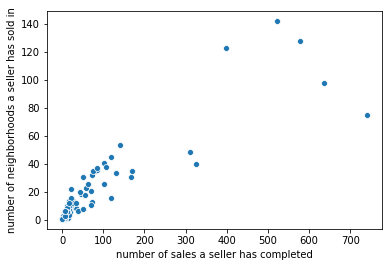

In [227]:
grps = X_train.groupby(['SellerG'])
seller_counts = []
seller_neighborhoods = []

for grp in grps:
#     print(grp[0], len(set(grp[1].Suburb)))
    seller_counts.append(len(grp[1]))
    seller_neighborhoods.append(len(set(grp[1].Suburb)))
#     break

ax = sns.scatterplot(seller_counts, seller_neighborhoods)
ax.set_xlabel('number of sales a seller has completed')
ax.set_ylabel('number of neighborhoods a seller has sold in')

In [238]:
top_sellers = X_train.groupby(['SellerG'])
seller_totals = []
sellers = []

for seller in top_sellers:
    sellers.append(seller[0])
    seller_totals.append(len(seller[1]))
    
df_tmp = pd.DataFrame({'seller': sellers, 'counts': seller_totals})

top_sellers = df_tmp.sort_values(by = 'counts', ascending = False).head(50)['seller']

In [189]:
#prepping training set

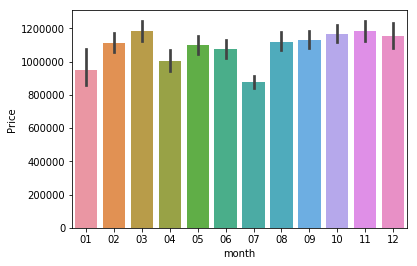

In [202]:
sns.barplot(x="month", y="Price", data=X_train)

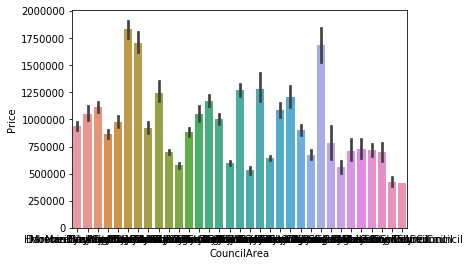

In [203]:
sns.barplot(x="CouncilArea", y="Price", data=X_train)

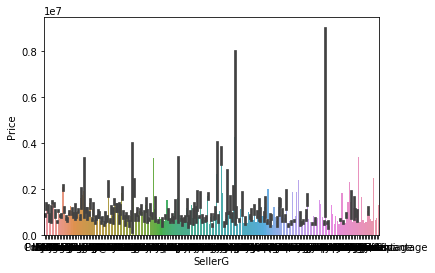

In [204]:
sns.barplot(x="SellerG", y="Price", data=X_train)

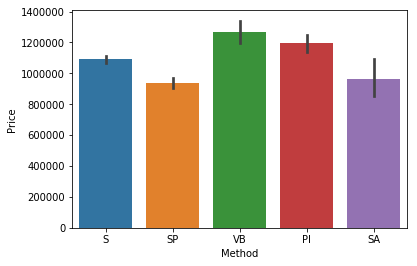

In [205]:
sns.barplot(x="Method", y="Price", data=X_train)

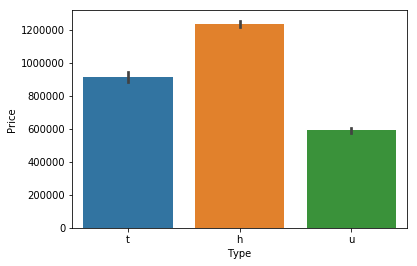

In [206]:
sns.barplot(x="Type", y="Price", data=X_train)

In [240]:
X_train.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode',
       ...
       'SellerG_YPA', 'SellerG_Zahn', 'SellerG_buyMyplace',
       'SellerG_hockingstuart', 'SellerG_hockingstuart/Biggin',
       'SellerG_hockingstuart/hockingstuart', 'SellerG_iOne',
       'SellerG_iProperty', 'SellerG_iSell', 'SellerG_iTRAK'],
      dtype='object', length=1201)

In [243]:
#prepping training set

X_train['month'] =[date.split('/')[1] for date in X_train['Date']]#
X_train['year'] =[float(date.split('/')[2]) for date in X_train['Date']]

break_out = ['Regionname', 'Suburb','Method', 'Type', 'month', 'CouncilArea',]
for col in break_out:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[col],prefix=col)], axis=1)
    
target = 'Price'
omit = ['Date', 'Address',  'SellerG'] #could split out street...

#keep these sellers
seller_labels = ['SellerG_'+seller for seller in top_sellers]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [244]:


y_train = X_train[target]
X_train = X_train.loc[:, ~(X_train.columns).isin([target]+omit+ break_out)]

X_train.columns[X_train.isna().any()].tolist()

[]

In [245]:
X_test['month'] =[date.split('/')[1] for date in X_test['Date']]#
X_test['year'] =[float(date.split('/')[2]) for date in X_test['Date']]

for col in break_out:
    X_test = pd.concat([X_test, pd.get_dummies(X_test[col],prefix=col)], axis=1)

y_test = X_test[target]
X_test = X_test.loc[:, ~(X_test.columns).isin([target]+omit+ break_out)]

overlap = list(set(X_test.columns).intersection(set(X_train.columns))) 
empties = [col for col in X_train.columns if col not in overlap]

empty_df = pd.DataFrame(0, index=X_test.index, columns=empties)

X_test = pd.concat([X_test[overlap], empty_df], axis=1, join_axes=[X_test.index])



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [247]:
len(overlap), len(empty_df.columns)

(332, 53)

In [246]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print(cross_val_score(lin_reg, X_train, y_train))

lin_reg.score(X_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[ 0.69348812  0.70316988  0.66347023]


-5196714.9241868844

In [251]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
svr = SVR()

print(cross_val_score(svr, X_train, y_train))
svr.score(X_test, y_test)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set 

[-0.09395142 -0.06960667 -0.08533693]


NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.